# Implementing and comparing LRP techniques
This notebook loads MNIST data (60 000 images), builds and trains a simple MLP with layer sizes 784x300x100x10, and implements Layer-wise Relevance Propagation to construct a heatmap of the input pixels which supposedly have the most impact on the output.

In [17]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
from relevancecmp import compare_relevance

## 0. Load datset

In [2]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

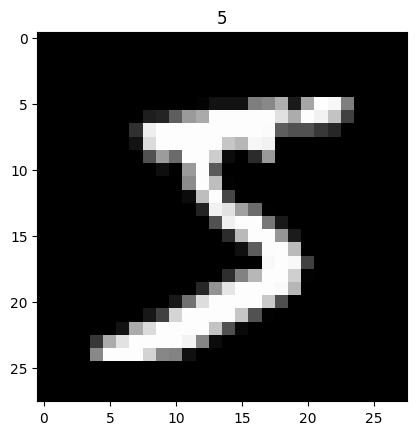

In [3]:
image, label = train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

In [4]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [5]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1. Train simple model

In [6]:
device = torch.device('mps')

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [8]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [9]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [10]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35103 | Test loss: 0.14001, Test acc: 95.68%


## 2. Attacks

Text(0.5, 1.0, '5')

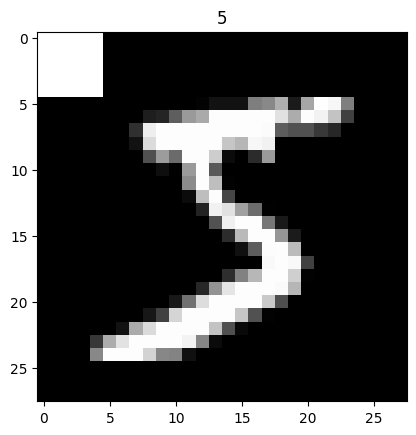

In [16]:
image, label = train[0]
image = image.squeeze()

xrange = range(0, 5)
yrange = range(0, 5)

for x in xrange:
    for y in yrange:
        image[y][x] = 1-image[y][x]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

In [95]:
from tqdm import tqdm

In [107]:
SUBSET = 1000

kernel_size = 4

kx_range = range(0, 28, 1)
ky_range = range(0, 28, 1)

accuracies = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]
losses = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]

for digit in tqdm(range(10)):
    for i, kx in enumerate(kx_range):
        for j, ky in enumerate(ky_range):
            def annotate_image(image):
                #image[ky:ky+kernel_size, kx:kx+kernel_size] = torch.rand(image[ky:ky+kernel_size, kx:kx+kernel_size].shape)
                image[ky:ky+kernel_size, kx:kx+kernel_size] = 1 - image[ky:ky+kernel_size, kx:kx+kernel_size]
                return image
                

            attack = datasets.MNIST(
                root="data",
                train=False,
                download=True,
                transform=Lambda(
                    lambda x: annotate_image(ToTensor()(x).squeeze())
                ),
            )
            attack = torch.utils.data.Subset(attack, range(SUBSET))

            #image, _ = attack[0]
            #plt.imshow(image.squeeze(), cmap="gray")
            #plt.title(label)
            #plt.show()

            attack_loader = DataLoader(
                torch.utils.data.Subset(attack, [i for i, (_, y) in enumerate(attack) if y == digit]),
                batch_size=BATCH_SIZE,
                shuffle=False
            )

            test_loss, test_acc = 0, 0
            model.eval()
            with torch.inference_mode():
                for X, y in attack_loader:
                    X, y = X.to(device), y.to(device)
                    test_pred = model(X)

                    test_loss += loss_fn(test_pred, y)
                    test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

                test_loss /= len(attack_loader)
                test_acc /= len(attack_loader)

            #print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
            accuracies[digit][j][i] = test_acc
            losses[digit][j][i] = test_loss

28it [00:31,  1.11s/it]00:00<?, ?it/s]
28it [00:32,  1.16s/it]00:31<04:39, 31.05s/it]
28it [00:32,  1.15s/it]01:03<04:15, 31.88s/it]
28it [00:31,  1.14s/it]01:35<03:43, 31.98s/it]
28it [00:32,  1.14s/it]02:07<03:11, 31.97s/it]
28it [00:30,  1.08s/it]02:39<02:39, 31.99s/it]
28it [00:31,  1.14s/it]03:09<02:05, 31.43s/it]
28it [00:33,  1.21s/it]03:41<01:34, 31.62s/it]
28it [00:31,  1.14s/it]04:15<01:04, 32.33s/it]
28it [00:31,  1.14s/it]04:47<00:32, 32.22s/it]
100%|██████████| 10/10 [05:19<00:00, 31.97s/it]


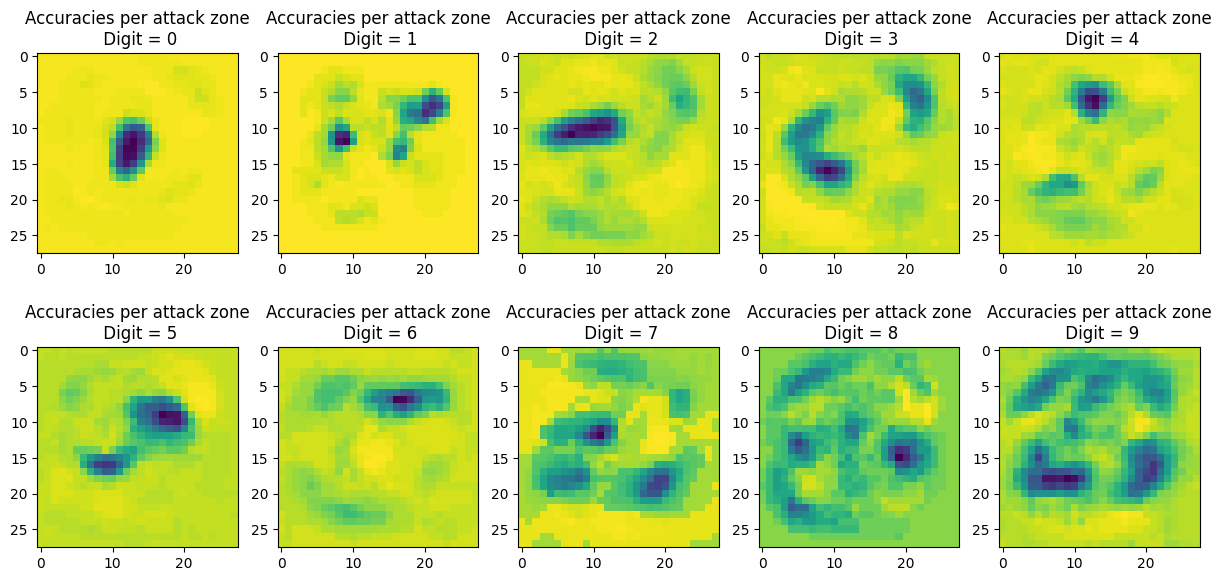

In [108]:
fig, axs = plt.subplots(2, 5, figsize=(15,7))

for i in range(10):
    axs[i//5][i%5].imshow(accuracies[i])
    axs[i//5][i%5].set_title(f"Accuracies per attack zone\n Digit = {i}")